# Neural Additive Models

## **1. Introduction**

This notebook contains examples to explain use of NAMs on tabular data using the [dnamite](https://dnamite.readthedocs.io/en/latest/index.html#) library. 

The library implements NAMs via the DNAMite architecture and fits the additive models using the following equation: 
$$
\text{f(x)} = g (\beta_0 + \sum_{j=1}^{p})s(\mu_j)f_j(X_j) + \sum_{j<k} + s(\mu_j,k)f_{j,k}(X_j, X_k)$$
where
- $g$ is link function based on the task.
- $ s(\mu_j)$, $s(\mu_j,k)$ are feature gates.
- $\beta_0$ is the intercept
- $f_j(X_j)$ are feature functions and $f_{j,k}(X_j, X_k)$ are feature interaction functions.

**DNAMITE ARCHITECTURE**
- Primarily created for survival analysis.
- Discretize all features using feature-specific bins in the feature embedding module.
- No preprocessing such as one hot encoding is required as the library handles that behind the scenes. 
- Smoothness of DNAMite’s shape function is parameter controlled.

![DNAMITE Architecture](dnamite-nam-arch.png)


This library was introduced in the paper:

Van Ness, M., Block, B. & Udell, M.. (2025). DNAMite: Interpretable Calibrated Survival Analysis with Discretized Additive Models. Proceedings of the 4th Machine Learning for Health Symposium, in Proceedings of Machine Learning Research 259:805-823 Available from https://proceedings.mlr.press/v259/van-ness25a.html.

We will explore 2 types of problems:

1. Binary Classification using [bank dataset](https://archive.ics.uci.edu/dataset/222/bank+marketing). 
2. Regression using [Gas Turbine dataset](https://archive.ics.uci.edu/dataset/551/gas+turbine+co+and+nox+emission+data+set).

## **1. Import Libraries**

In [1]:
import os
import random

import torch
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from dnamite.models import DNAMiteBinaryClassifier, DNAMiteRegressor
from sklearn.metrics import roc_auc_score, confusion_matrix,  ConfusionMatrixDisplay, mean_squared_error, r2_score


## **2. Binary classification with NAMs**

### **2a Load and preprocess Portugese bank dataset**


This dataset contains phone call records of a marketing campaign conducted by a Portugese bank. The classification goal is to predict if the client will subscribe (yes/no) a term deposit (variable y).


In [2]:
df = pd.read_csv('../datasets/bank_marketing/bank-full.csv', delimiter=';')   
display(df.head())

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [3]:
# Automatically determine categorical and numerical features
categorical_features = df.select_dtypes(include=["object", "category"]).columns.tolist()
numerical_features = df.select_dtypes(include=["number"]).columns.tolist()

print("Categorical Features:", categorical_features)
print("Numerical Features:", numerical_features)


# Remove the target variable (if included in the dataset)
target_variable = "y"
categorical_features.remove(target_variable)
    
# Define the ColumnTransformer
one_hot_encoder = OneHotEncoder(sparse_output=False)
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", scaler, numerical_features),   # Scale numerical features
        ("cat", one_hot_encoder, categorical_features)  # One-hot encode categorical features
    ]
)

print(df.columns)

# Separate features and target
X = df.drop([target_variable], axis=1)
y = df[target_variable]


# Convert true labels to binary format
y= (y == 'yes').astype(int)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


Categorical Features: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'y']
Numerical Features: ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')


### 2b. Train a Binary Classifier

The classifier is derived from DNAMITE Architecture.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_bc = DNAMiteBinaryClassifier(
    n_features=X_train.shape[1],
    device=device,
    random_state=34
)
model_bc.fit(X_train, y_train)



In [5]:
model_bc_pairwise = DNAMiteBinaryClassifier(
    n_features=X_train.shape[1],
    device=device,
    num_pairs=8, #Number of pairwise interactions to use in the model.
    random_state=34
)
model_bc_pairwise.fit(X_train, y_train)


### 2c. Predict outputs

Accuracy for simple binary classification:  0.9029083268826716
Accuracy for pairwise binary classification:  0.9072210549596373


ROC AUC for simple binary classification: 0.9150973055575612
ROC AUC for simple pairwise binary classification: 0.9281089424523533


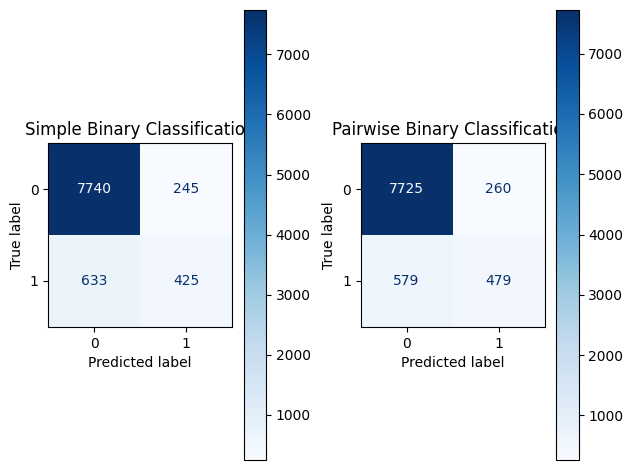

In [7]:
#Predict outputs
outputs_bc = model_bc.predict_proba(X_test)
predicted_bc = outputs_bc > 0.5
#outputs, predicted = outputs, predicted
outputs_bc_pairwise = model_bc_pairwise.predict_proba(X_test)
predicted_bc_pairwise = outputs_bc_pairwise > 0.5

#Calculate accuracy
total = y_test.shape[0]
correct_bc = (predicted_bc == y_test).sum().item()
accuracy_bc = correct_bc / total
correct_bc_pairwise = (predicted_bc_pairwise == y_test).sum().item()
accuracy_bc_pairwise = correct_bc_pairwise / total
print('Accuracy for simple binary classification: ', accuracy_bc)
print('Accuracy for pairwise binary classification: ', accuracy_bc_pairwise)

print('\n')
#Calculate AUC score
roc_auc_bc = roc_auc_score(y_test, outputs_bc)
roc_auc_bc_pairwise = roc_auc_score(y_test, outputs_bc_pairwise)
print('ROC AUC for simple binary classification:', roc_auc_bc)
print('ROC AUC for simple pairwise binary classification:', roc_auc_bc_pairwise)

conf_mat_bc = confusion_matrix(y_test, predicted_bc)
conf_mat_bc_pairwise = confusion_matrix(y_test, predicted_bc_pairwise)

# Plot confusion matrix
fig, ax = plt.subplots(1, 2)
ax[0].set_title("Simple Binary Classification")
ax[1].set_title("Pairwise Binary Classification")
ConfusionMatrixDisplay(confusion_matrix=conf_mat_bc).plot(cmap='Blues', values_format='d', ax=ax[0])
ConfusionMatrixDisplay(confusion_matrix=conf_mat_bc_pairwise).plot(cmap='Blues', values_format='d', ax=ax[1])
plt.tight_layout()
plt.show()


- We train 2 models, One without any pairwise interactions and one with 10 pairwise interactions. The second model provides higher accuracy by 1%. Since we don't gain much increase in accuracy, we can assume that the features are fairly independent to each other.

- In the [ig-tabular.ipynb](https://github.com/VectorInstitute/interpretability-bootcamp/blob/main/reference_implementations/Post-hoc/integrated_gradients/ig-tabular.ipynb) notebook, we used a 4 Layer MLP with ReLU activations to classify `y`. Copying the metrics here - 

 - Accuracy:  0.8499391794758376
 - ROC AUC: 0.9154654935470926
 - Confusion matrix:
| | 0 | 1 |
|---| --- | --- |
| 0 | 6806 | 1179 |
| 1 | 178 | 880 |

Comparing Accuracy and Confusion matrices between the Gradient Boosting method and NAM, it looks like NAM is **better at classification** with **higher** accuracy. 

### **2d. Interpretability of simple model**

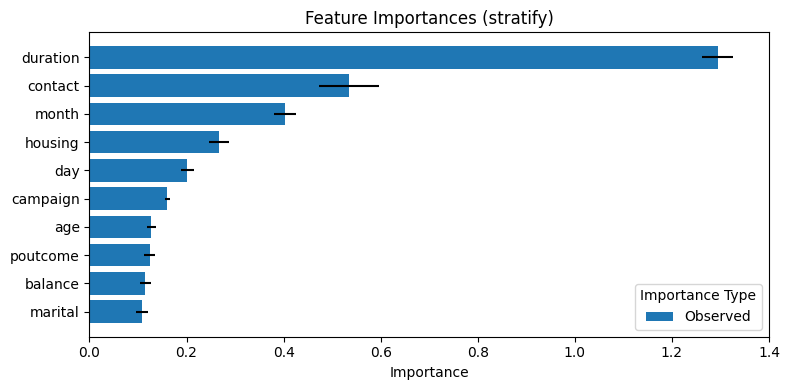

In [6]:
model_bc.plot_feature_importances(n_features=10, missing_bin='stratify')

- `Duration` : This feature represents the duration of the sales call. This is very important as the longer the duration, the higher chance of someone signing up for term deposit. 
- `Contact`: This feature is a categorical variable representing the mode of communication. It can have one of the  3 values [Telephonic, Cellular, Unknown]. **Not sure if there is explanation as to why this can be an important factor affecting the subscription outcome.**
- `Month`: This is a categorical feature representing the last month in which the call was made. Values are in [Jan, Feb...Dec]. This can be significant due to seasonal cycles (tax season, bonus season etc.) in the fiscal year where some cycles can significantly affect the outcome.
- `Housing`: This binary feature represents if the client has a housing loan or not. If the client has a loan, its possible they may not want to subscribe to a term deposit. 
- `Day`: This is the last contact day of the month with values between [1-31]. **Not sure if there is explanation as to why this can be an important factor affecting the subscription outcome.** Unless there is a granular feature where weekend calls are marked and there is high likelihood of a person picking up the phone call, we cannot say why this is relevant.
- `Campaign`: This is a numeric feature which denotes the total number of calls made to a client for the campaign period. Its possible that the more number of calls made to the client, the less likely the client is willing to subscribe due to irritation.
- `Age`: This is a numeric feature which is the age of the client. This can be a factor in one's risk taking attitude, along with a person's financial and personal status. So, this makes sense.
- `poutcome`: This is a categorical feature representing the outcome of previous campaign. Values are in the categories ["unknown", "other", "failure", "success"]. Its possible that if a person has subscribed once via the phone sales campaign, they are more likely to subscribe to another one as its proven that they are open to it.
- `balance`: This is a numerical feature which is the average yearly balance. A persons financial condition can play a role in their flexibility to lock money away in a term deposit. 
- `marital`: This is a categorical feature which denotes the marital status of the client. Values are in one of the categories ["married", "divorced", "single"]. This life stage can affect how many responsibilities they have and how flexible they are with their finances.

#### Quick check of accuracy if we drop the above 2 features.

The accuracy and AUC remains almost the same if we remove the two features. So, their significance calculated may not be as accurate. 

Accuracy: 0.9015813336282207
AUC ROC: 0.9139404815030071

**Such insights are useful in choosing a model. Even if DNAMITE is giving higher accuracy than GBR, since it is using features which may not have a clear explainability, we can choose not to use this model.**

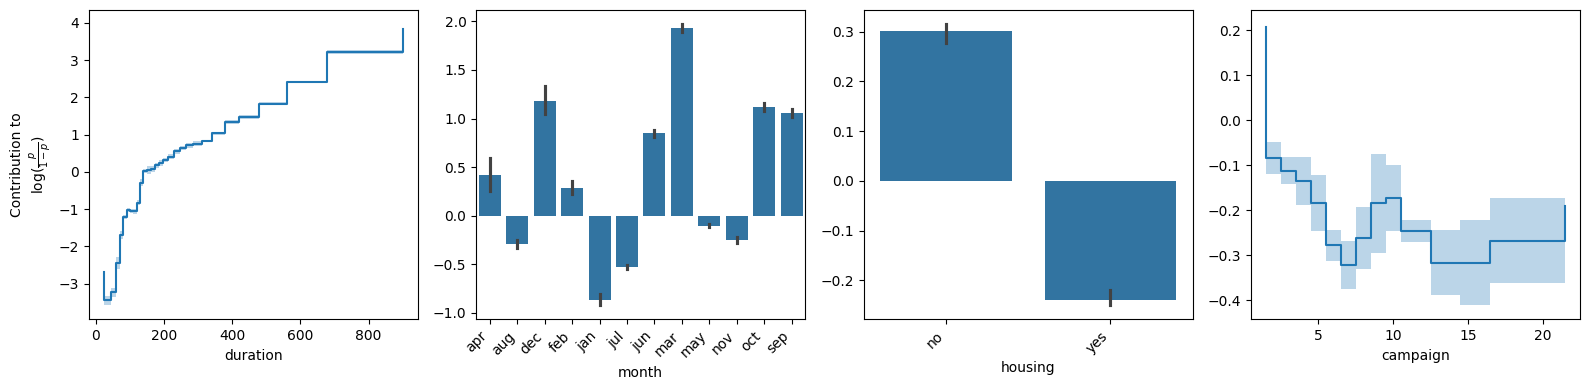

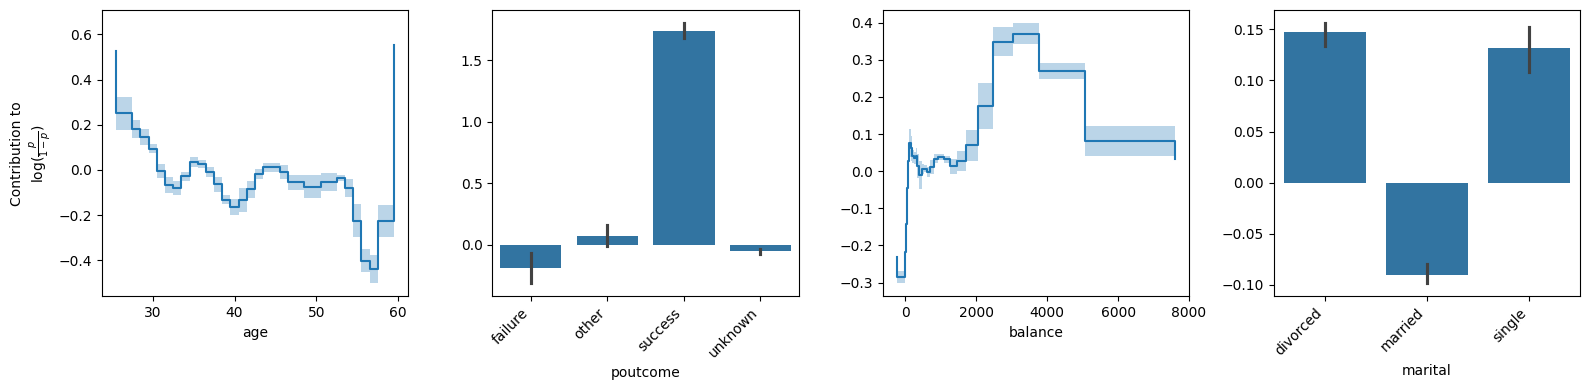

In [28]:
model_bc.plot_shape_function(['duration', 'month', 'housing', 'campaign',])
model_bc.plot(['age', 'poutcome', 'balance', 'marital' ])

- `housing` - Client has a higher chance of taking a term deposit if they have no housing loan.
- `duration` - If the duration of the client is approx. >200 secs (3 minutes), then the client is probably listening to the details of the sale and pondering over it. Higher the call duration, the more likely they are interested.
- `age` and `marital` - If the client is < 30 years old, or not married, the higher they are likely to subscribe to the deposit. In either category, its possible that they have less responsibilities and more flexibility with their finances.
- `poutcome` - If the client has subscribed to a term deposit via sales call before, it shows that they are highly likely to do so again.
- `campaign` - If the client wants to close the deal, they will likely do so in ~ 1/2 phone calls.

## **3. REGRESSION**

### **3a. Load and preprocess dataset**

The regression task is performed on the Gas Turbine CO and NOx Emission Data Set to predict the value of Turbine Energy Yield `TEY`. 

In [54]:
# Define the folder path
folder_path = '../datasets/gas+turbine+co+and+nox+emission+data+set'

# Load the CSV files
files_to_load = ['gt_2011.csv', 'gt_2012.csv', 'gt_2013.csv', 'gt_2014.csv']
dataframes = [pd.read_csv(os.path.join(folder_path, file)) for file in files_to_load]


# Concatenate the dataframes
train_data = pd.concat(dataframes, ignore_index=True)
display(train_data.head())

# Load the test data
test_data = pd.read_csv(os.path.join(folder_path, 'gt_2015.csv'))


scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)


# Split the training and validation data
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

#use column TEY as target
target = 'TEY'
X_train = train_data.drop(target, axis=1)
y_train = train_data[target]
X_test = test_data.drop(target, axis=1)
y_test = test_data[target]



# Print the shapes of the datasets
print(f'Training data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028


Training data shape: (23479, 11)
Test data shape: (7384, 11)


### **3b. Train model**

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_reg = DNAMiteRegressor(
    n_features=X_train.shape[1],
    device=device,
    num_pairs=1, #Number of pairwise interactions to use in the model.
    random_state=42,
)

In [56]:
model_reg.fit(X_train, y_train)

### **3c. Predict outputs**

In [57]:
y_preds = model_reg.predict(X_test)

In [58]:
mse_test = mean_squared_error(y_test, y_preds)

print(f'Mean Squared Error on test data: {mse_test:.4f}')
r2 = r2_score(y_test, y_preds)
print(f'R2 score on test data: {r2:.4f}')

Mean Squared Error on test data: 0.0202
R2 score on test data: 0.9815


### 3d. Interpretability

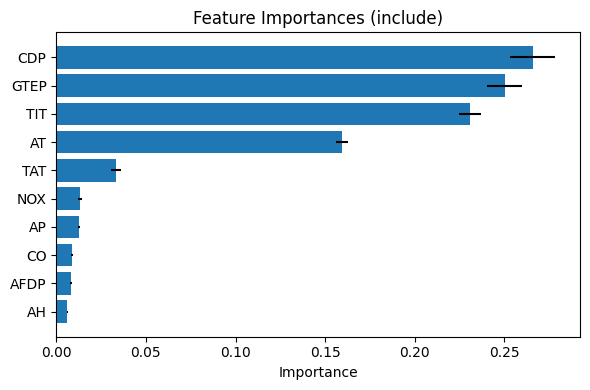

In [59]:
model_reg.plot_feature_importances(n_features=10)

The model determines about 5 features of significant importance which affect the output of the model. `GTEP`, `CDP`, `TAT`, `TIT` are turbine parameters, and have very high individual Pearson correlations with the output variable `TEY` as shown in the [original paper](https://journals.tubitak.gov.tr/cgi/viewcontent.cgi?article=1505&context=elektrik).

1. corr(CDP, TEY) = 0.99
2. corr(GTEP, TEY) = 0.96
3. corr(TIT, TEY) = 0.91
4. corr(TAT, TEY) = -0.68

Even though the prediction values on the test set are low, feature importance values the 4 features calculated by the DNAMITE model are in tandem with the original dataset paper. 

However, corr(AT, TEY) = -0.09 which is very low, but the importance given to this feature here is very high. So, not all importance values corroborate.



The above feature list also has an overlap with the interpretable method `DecisionTreeRegressor` as shown in the [lime-jupyter.ipynb](https://github.com/VectorInstitute/interpretability-bootcamp/blob/main/reference_implementations/Post-hoc/LIME/lime-jupyter.ipynb) notebook. `CDP` and `AT` are determined to have the highest information for regression within the decision tree, which are also a part of the top 5 features here.

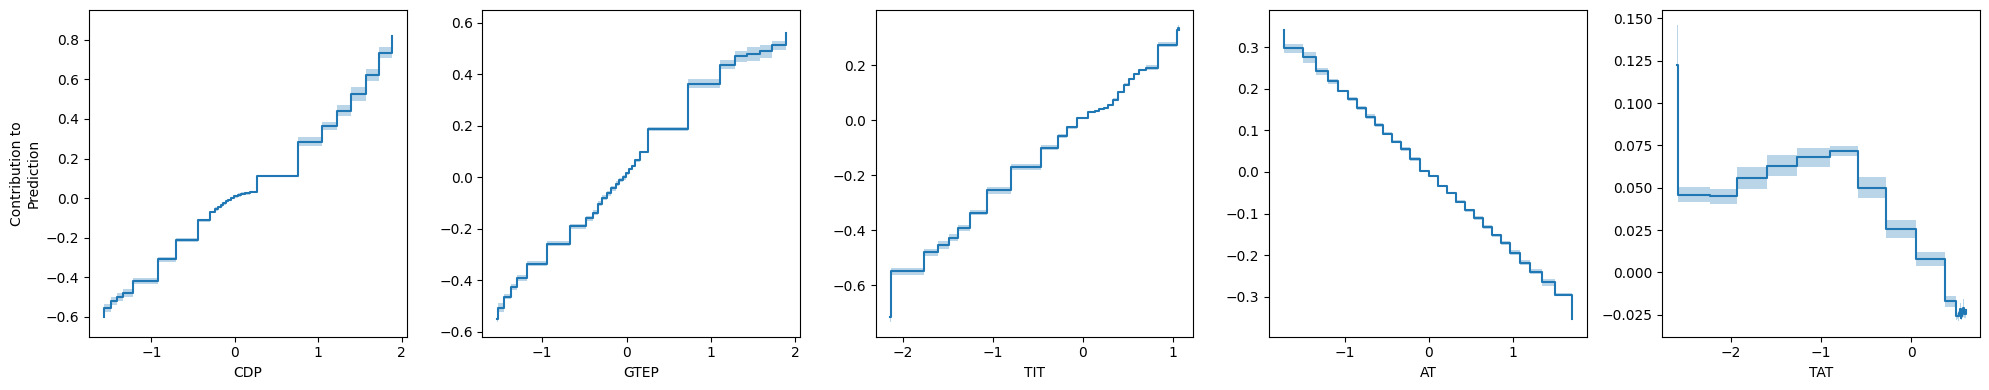

In [60]:
model_reg.plot_shape_function(['CDP', 'GTEP', 'TIT', 'AT', 'TAT'])

- Higher values of `CDP`, `GTEP` and `TIT` add to the prediction of `TEY`. 
    - Compressor and turbine inlet pressures impact performance, and a low compressor discharge pressure (`CDP`) reduces efficiency.
    - Inefficient `GTEP` or Gas turbine exhaust pressure can also reduce power generation. 
    - At lower `TIT`, combustion may be incomplete, reducing energy yield. The non-linear pattern of `TIT` might also indicate interactions with other features.
- Only really low values of `AT` and `TAT` contribute to the prediction. 
    - Cooler temperatures (low `AT`) improve efficiency, which aligns with real-world turbine behavior (lower temperatures improve air density and combustion). Increased `AT` lowers the density of the inlet air, thus reducing the mass flow through the turbine, and therefore reduces the power output.
    -  For `TAT`, it looks like a slight decrease in value (< -2) increases its contribution to the prediction by a large margin (0.05 -> 0.125). Excessive TAT might indicate inefficient cooling or energy loss, reducing the turbine's performance. 